In [1]:
#one layer perceptron, mlp, then cnn 
#play with filter size\s
#triple check data loading process
#

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image

## Data and Loaders

In [3]:
cd ../../../Noah

/mnt/pesaranlab/People/Capstone_students/Noah


In [4]:
moving_files_train = []
moving_files_val = []
for ind, f in enumerate(os.listdir('data/move/')):
    x = np.load('data/move/'+f)
    l = np.split(x,62)
    if ('0413' in f) or ('0414' in f):
        for arr in l:
            moving_files_val.append((arr,1))
    else:
        for arr in l:
            moving_files_train.append((arr,1))
        
sleeping_files_train = []
sleeping_files_val = []
for ind, f in enumerate(os.listdir('data/sleep/')):
    x = np.load('data/sleep/'+f)
    l = np.split(x,62)
    if ('0413' in f) or ('0414' in f):
        for arr in l:
            sleeping_files_val.append((arr,0))
    else:
        for arr in l:
            sleeping_files_train.append((arr,0))

In [ ]:
moving_files_val[0][0].shape

In [ ]:
moving_files_val[0][1]
plt.imshow(moving_files_val[0][0][0])
plt.show()

In [7]:
len(moving_files_train), len(moving_files_val), len(sleeping_files_train), len(sleeping_files_val)

(133672, 40486, 764770, 122078)

In [8]:
import random
diff_train = len(sleeping_files_train)-len(moving_files_train)
for i in range(diff_train):
    ind = random.randint(0,len(moving_files_train)-1)
    x= moving_files_train[ind]
    moving_files_train.append(x)

In [9]:
len(moving_files_train), len(moving_files_val), len(sleeping_files_train), len(sleeping_files_val)

(764770, 40486, 764770, 122078)

In [10]:
train_files = moving_files_train+sleeping_files_train
val_files = moving_files_val+sleeping_files_val

In [11]:
len(train_files)

1529540

In [12]:
# change this to access batch only when necessary
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train', train_files = train_files, val_files = val_files):
        self.train_files = train_files
        self.val_files = val_files
        if mode == 'train':
            self.files = self.train_files
        elif mode == 'val':
            self.files = self.val_files
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        spec = torch.from_numpy(self.files[idx][0])
        label = torch.tensor(self.files[idx][1])
        return  spec, label

In [13]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='val')

In [14]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 32, shuffle = False)

In [15]:
len(train_dataset), len(train_loader)

(1529540, 47799)

In [16]:
len(valid_dataset), len(val_loader)

(162564, 5081)

## Train and Test Functions

In [18]:
def train(loader):
    model.train()
    batch_losses = []
    
    for batch_idx, (data, labels) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device).float()
        
        if (torch.isinf(data).any()) or (torch.isnan(data).any()):
            continue
        
        preds = model(data).flatten()
        if (type(model) != CNN):
#             print(preds.size(), labels.size())
            loss = criterion(preds, labels)
        else:
            loss = criterion(preds[0], labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
    epoch_loss = sum(batch_losses)/len(batch_losses)
    
    return(epoch_loss)

In [19]:
def test(loader):
    model.eval()
    batch_losses = []
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            preds = model(data)
            if type(model != CNN):
                loss = criterion(preds, labels)
            else:
                loss = criterion(preds[0], labels)
            
            batch_losses.append(loss)
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        return epoch_loss

## LogReg

In [20]:
class LogReg(nn.Module):
    def __init__(self, num_classes = 1):
        super(LogReg, self).__init__()
        self.fc1 = nn.Linear(100*10, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

In [ ]:
input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LogReg().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)



epochs = []
training_losses = []
val_losses = []
for epoch in range(num_epochs):
    avg_train_loss = train(train_loader)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    val_losses.append(val_loss)

Train loss for epoch 0: 0.4504779577255249


/home/bijanadmin/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/bijanadmin/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Val loss for epoch 0: 0.45320847630500793
Train loss for epoch 1: 0.4428386986255646
Val loss for epoch 1: 0.43033352494239807
Train loss for epoch 2: 0.4400116205215454
Val loss for epoch 2: 0.4436015188694
Train loss for epoch 3: 0.43880927562713623
Val loss for epoch 3: 0.46011191606521606


## Dumb CNN

In [17]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(4*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
        x2 = relu(self.conv2(x1))
        x = x2.reshape(x2.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, x2

In [18]:
#Think about kernel size... maybe 10x3? or 10x10?
#also think about padding - 

In [19]:
import torch
print(torch.__version__)

1.6.0


In [20]:

print(device)

cuda


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 10

model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

NameError: name 'model' is not defined

In [30]:
def test(loader):
    model.eval()
    batch_losses = []
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            preds = model(data)
            if type(model == MLP):
                loss = criterion(preds, labels)
            else:
                loss = criterion(preds[0], labels)
            
            batch_losses.append(loss)
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        return epoch_loss

In [37]:
model = CNN().to(device)

epochs = []
training_losses = []
val_losses = []
for epoch in range(num_epochs):
    avg_train_loss = train(train_loader)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    val_losses.append(val_loss)

NameError: name 'MLP' is not defined

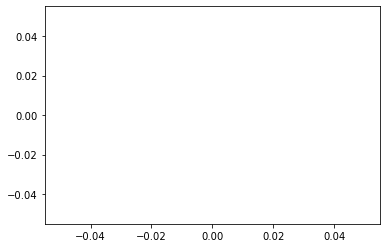

In [32]:
plt.plot(training_losses,linewidth = 3)

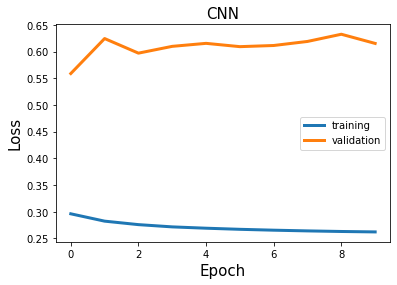

In [43]:
plt.title("CNN", fontsize = 15)
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.plot(training_losses,linewidth = 3,label='training')
plt.plot(val_losses, linewidth = 3,label='validation')
plt.legend()

In [45]:
for batch_idx, (data, labels) in enumerate(train_loader):
    data = data.to(device)
    x, conv1, conv2 = model(data)
    break

In [47]:
conv1.shape

torch.Size([32, 2, 10, 100])

In [54]:
conv1[0][0]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5371e-02,
         0.0000e+00, 2.6164e-02, 4.1993e-03, 2.9487e-02, 8.2544e-03, 4.2307e-02,
         8.6291e-02, 1.2355e-01, 1.8316e-01, 1.6556e-01, 1.9468e-01, 1.2017e-01,
         7.5407e-02, 8.4381e-02, 9.2642e-02, 4.9729e-03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

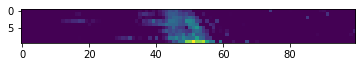

In [60]:
#conv1[0][0].
plt.imshow(conv1[0][0].cpu().detach().numpy())

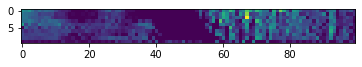

In [59]:
plt.imshow(conv1[0][1].cpu().detach().numpy())

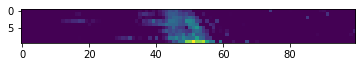

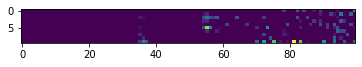

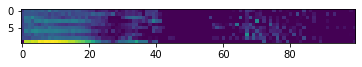

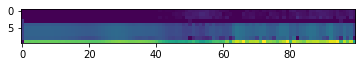

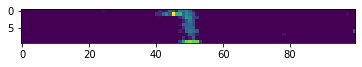

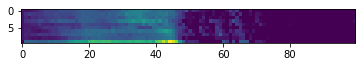

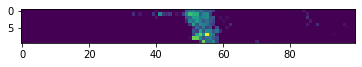

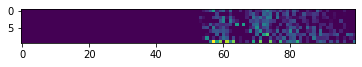

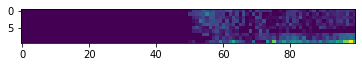

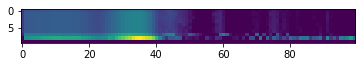

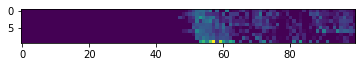

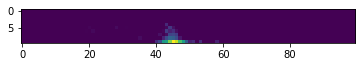

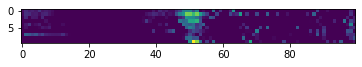

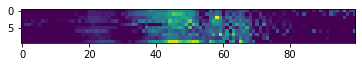

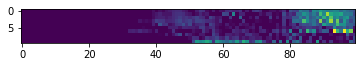

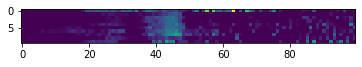

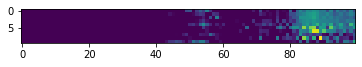

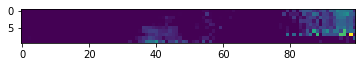

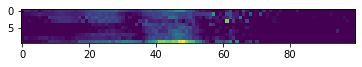

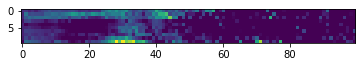

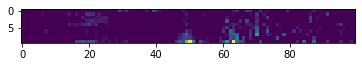

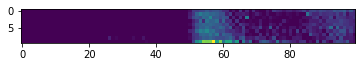

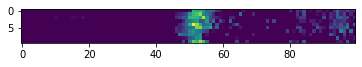

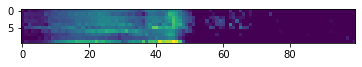

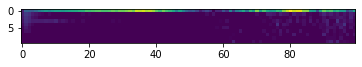

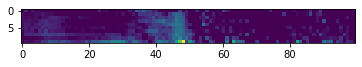

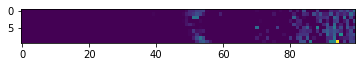

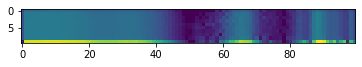

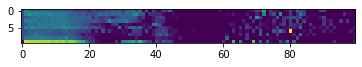

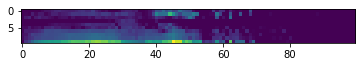

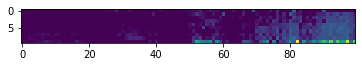

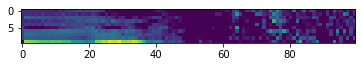

################################################


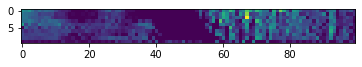

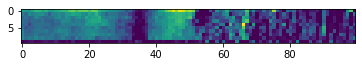

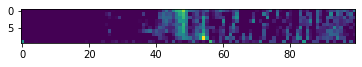

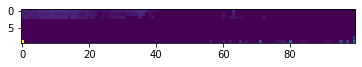

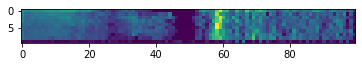

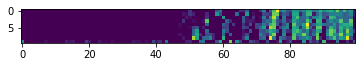

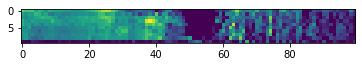

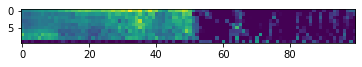

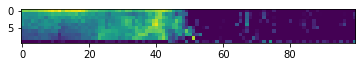

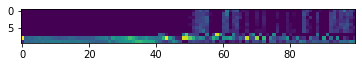

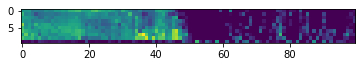

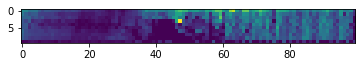

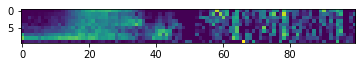

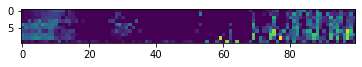

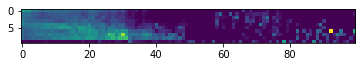

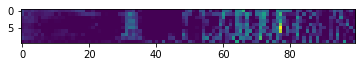

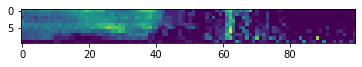

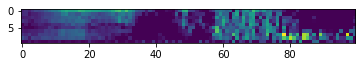

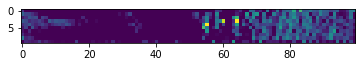

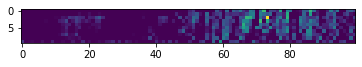

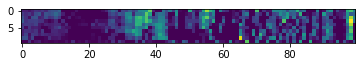

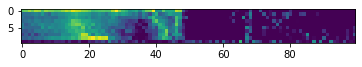

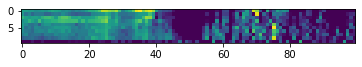

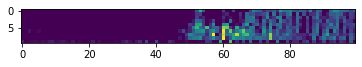

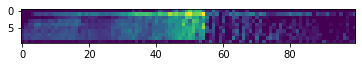

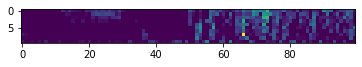

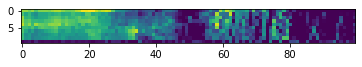

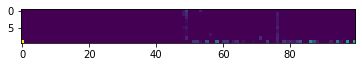

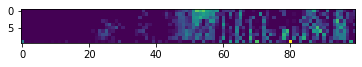

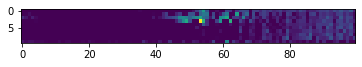

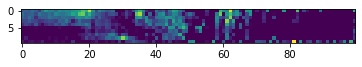

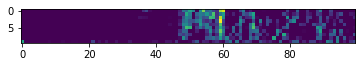

################################################


In [70]:
for j in range(2):
    for i in range(32):
        plt.imshow(conv1[i][j].cpu().detach().numpy())
        plt.show()
    print('################################################')

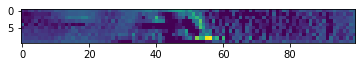

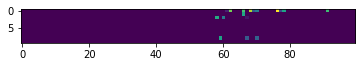

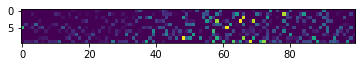

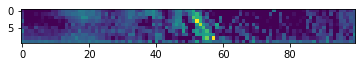

In [68]:
for i in range(4):
    plt.imshow(conv2[0][i].cpu().detach().numpy())
    plt.show()

In [30]:
train_files[0][0].shape

(1, 10, 100)

In [31]:
train_dataset_short = NoahSpectrogramDataset(mode='train', train_files=[train_files[0]], val_files=[val_files[0]])
valid_dataset_short = NoahSpectrogramDataset(mode='val', train_files=[train_files[0]], val_files=[val_files[0]])

In [32]:
train_loader_short = DataLoader(dataset = train_dataset_short, batch_size = 1, shuffle = True)
val_loader_short = DataLoader(dataset = valid_dataset_short, batch_size = 1, shuffle = False)

In [33]:
model = CNN().to(device)

epochs = []
training_losses = []
val_losses = []
for epoch in range(num_epochs):
    avg_train_loss = train(train_loader_short)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss = test(val_loader_short)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    val_losses.append(val_loss)

Train loss for epoch 0: 0.8294748067855835
Val loss for epoch 0: 0.6912071704864502
Train loss for epoch 1: 0.8294748067855835
Val loss for epoch 1: 0.6912071704864502
Train loss for epoch 2: 0.8294748067855835
Val loss for epoch 2: 0.6912071704864502
Train loss for epoch 3: 0.8294748067855835
Val loss for epoch 3: 0.6912071704864502
Train loss for epoch 4: 0.8294748067855835
Val loss for epoch 4: 0.6912071704864502
Train loss for epoch 5: 0.8294748067855835
Val loss for epoch 5: 0.6912071704864502
Train loss for epoch 6: 0.8294748067855835
Val loss for epoch 6: 0.6912071704864502
Train loss for epoch 7: 0.8294748067855835
Val loss for epoch 7: 0.6912071704864502
Train loss for epoch 8: 0.8294748067855835
Val loss for epoch 8: 0.6912071704864502
Train loss for epoch 9: 0.8294748067855835
Val loss for epoch 9: 0.6912071704864502


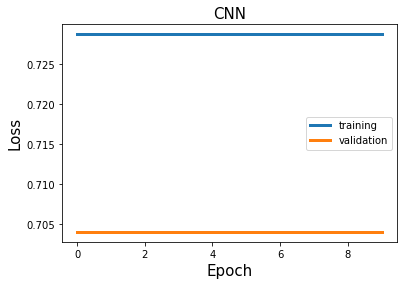

In [39]:
plt.title("CNN", fontsize = 15)
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.plot(training_losses,linewidth = 3,label='training')
plt.plot(val_losses, linewidth = 3,label='validation')
plt.legend()

# Dropout CNN

In [65]:
train_dataset_short = NoahSpectrogramDataset(mode='train', moving_files_train=[moving_files_train[0]], sleeping_files_train=[sleeping_files_train[0]], moving_files_val=[moving_files_val[0]], sleeping_files_val=[sleeping_files_val[0]])
valid_dataset_short = NoahSpectrogramDataset(mode='val', moving_files_train=[moving_files_train[0]], sleeping_files_train=[sleeping_files_train[0]], moving_files_val=[moving_files_val[0]], sleeping_files_val=[sleeping_files_val[0]])

In [66]:
train_loader_short = DataLoader(dataset = train_dataset_short, batch_size = 8, shuffle = True)
val_loader_short = DataLoader(dataset = valid_dataset_short, batch_size = 8, shuffle = False)

In [31]:
class CNN_dropout(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNN_dropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x = self.dropout(relu(self.conv1(x)))
        x = self.dropout(relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x

In [35]:
model = CNN().to(device)

epochs = []
training_losses = []
val_losses = []
for epoch in range(num_epochs):
    avg_train_loss = train(train_loader_short)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss = test(val_loader_short)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    val_losses.append(val_loss)

tensor([[[[-0.6602, -0.6411, -0.6599,  ..., -0.2444, -0.3326, -0.3789],
          [-0.5048, -0.5351, -0.5129,  ..., -0.2184, -0.3419, -0.1706],
          [-0.6619, -0.6441, -0.6435,  ..., -0.2472, -0.2126, -0.1897],
          ...,
          [-1.0016, -0.7627, -0.8041,  ..., -0.5967, -0.2192, -0.4165],
          [-0.6148, -0.5947, -0.5156,  ..., -0.7055, -0.1567, -0.3844],
          [-0.6589, -0.4759, -0.5359,  ..., -0.6028, -0.1390, -0.3672]]],


        [[[-1.1477, -1.0516, -0.9874,  ..., -0.3684, -0.4738, -0.0843],
          [-1.0413, -1.1383, -0.8789,  ..., -0.3840, -0.3266, -0.0399],
          [-1.0199, -1.0703, -1.0108,  ..., -0.2853, -0.1422,  0.0270],
          ...,
          [-1.6792, -1.6982, -1.6927,  ...,  0.0774,  0.2190, -0.1279],
          [-1.5734, -1.5991, -1.6248,  ..., -0.0161, -0.1288, -0.2537],
          [-1.5531, -1.5434, -1.5460,  ...,  0.2551, -0.2192, -0.2436]]]],
       device='cuda:0', dtype=torch.float64) tensor([0., 1.], device='cuda:0')
Train loss for epoch

## MLP

In [38]:
class MLP(nn.Module):
    def __init__(self, num_classes = 1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(100*10, 200)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(200, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], -1)
        x = relu(self.fc1(x))
        x = self.dropout(x)
        x = relu(self.fc2(x)).flatten()
        x = self.sigmoid(x)
        return x

In [39]:
model = MLP().to(device)

In [81]:
type(model) == MLP

True

In [ ]:
input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 10

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)



epochs = []
training_losses = []
val_losses = []
for epoch in range(num_epochs):
    avg_train_loss = train(train_loader)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    val_losses.append(val_loss)

In [24]:
model = LogReg().to(device)

/home/bijanadmin/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


RuntimeError: cuda runtime error (710) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/THC/THCStorage.cpp:49